# Sentiment140 Analysis - NLP Sentiment Classification

**Student ID:** 202210221  
**Student Name:** Ahmad Abu Ghazaleh  
**Project:** DS&AI Projects - SQA Implementation

## Objective
Classify sentiment (positive/negative) of tweets using Natural Language Processing on the Sentiment140 dataset (1.6 million tweets).

**Target Metrics:** Accuracy, Precision, Recall, F1-Score as per SQA Plan

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.4.0


## 1. Data Integrity Testing (Unit Testing Phase)

According to SQA Plan:
- Dataset must be "clean" (0 null values in selected features)
- 1.6 million tweets to process
- Binary classification: Positive (4) vs Negative (0)

In [3]:
# Load Sentiment140 dataset
# Note: Dataset has no header, we'll add column names
# Columns: target, ids, date, flag, user, text

# For initial testing, let's load a sample first to verify structure
print("Loading Sentiment140 dataset...")
print("Note: This is a large dataset (1.6M tweets), may take 10-20 seconds")

# Load with proper column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

try:
    df = pd.read_csv(
        '../datasets/sentiment140/sentiment140.csv',
        encoding='latin-1',  # Dataset uses latin-1 encoding
        header=None,
        names=column_names
    )
    print(f"✓ Dataset loaded successfully")
except FileNotFoundError:
    print("❌ Error: Dataset file not found!")
    print("Please ensure 'sentiment140.csv' is in datasets/sentiment140/ folder")
    raise

print(f"\nDataset Shape: {df.shape}")
print(f"Total tweets: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

Loading Sentiment140 dataset...
Note: This is a large dataset (1.6M tweets), may take 10-20 seconds
✓ Dataset loaded successfully

Dataset Shape: (1600000, 6)
Total tweets: 1,600,000
Columns: 6


In [4]:
# Display basic information
print("="*60)
print("DATASET INFORMATION")
print("="*60)

print("\nFirst 5 rows:")
print(df.head())

print("\n" + "="*60)
print("DATA TYPES")
print("="*60)
print(df.dtypes)

print("\n" + "="*60)
print("TARGET DISTRIBUTION")
print("="*60)
print(df['target'].value_counts())
print(f"\nTarget values: {df['target'].unique()}")
print("Note: 0 = Negative sentiment, 4 = Positive sentiment")

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
print(missing)
if missing.sum() == 0:
    print("\n✓ No missing values detected")
else:
    print(f"\n⚠️  Total missing values: {missing.sum()}")

DATASET INFORMATION

First 5 rows:
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user  \
0  _TheSpecialOne_   
1    scotthamilton   
2         mattycus   
3          ElleCTF   
4           Karoli   

                                                                                                  text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...  
1  is upset that he can't update his Facebook by texting it... and might cry as a result  School to...  
2            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds  
3                    

## 2. Data Sampling Strategy

**Challenge:** 1.6M tweets is computationally expensive for training.

**SQA Approach:**
- For development and testing, we'll use a **stratified sample**
- Sample size: 1000 tweets (500 positive, 500 negative)
- This maintains class balance and reduces training time
- Results can be validated on full dataset if needed

**Note:** This is a standard practice in ML development and won't compromise SQA quality standards.

In [147]:
np.random.seed(6261)
# Sample data for efficient processing
# BUG: We'll use random sampling WITHOUT stratification
# This may cause class imbalance issues

print("Sampling strategy for efficient processing:")
print("="*60)

# BUG: Random sampling without stratification
sample_size = 1000

# This is WRONG - doesn't maintain class balance
df_sample = df.sample(n=sample_size)

print(f"Original dataset: {df.shape[0]:,} tweets")
print(f"Sampled dataset: {df_sample.shape[0]:,} tweets")
print(f"Sample percentage: {(sample_size / df.shape[0]) * 100:.1f}%")

# Check class distribution
print(f"\nClass distribution in sample:")
print(df_sample['target'].value_counts())
print(f"\nClass proportions:")
print(df_sample['target'].value_counts(normalize=True))

# Check if balanced
pos_count = (df_sample['target'] == 4).sum()
neg_count = (df_sample['target'] == 0).sum()
balance_ratio = pos_count / neg_count

print(f"\nBalance check:")
print(f"  Positive samples: {pos_count:,}")
print(f"  Negative samples: {neg_count:,}")
print(f"  Balance ratio: {balance_ratio:.3f}")

if abs(balance_ratio - 1.0) > 0.05:  # More than 5% imbalance
    print(f"  ⚠️  WARNING: Class imbalance detected! Ratio should be ~1.0")
else:
    print(f"  ✓ Classes are balanced")

Sampling strategy for efficient processing:
Original dataset: 1,600,000 tweets
Sampled dataset: 1,000 tweets
Sample percentage: 0.1%

Class distribution in sample:
target
0    569
4    431
Name: count, dtype: int64

Class proportions:
target
0    0.569
4    0.431
Name: proportion, dtype: float64

Balance check:
  Positive samples: 431
  Negative samples: 569
  Balance ratio: 0.757
  ⚠️  WARNING: Class imbalance detected! Ratio should be ~1.0


## 3. Text Preprocessing

NLP Pipeline:
1. Convert target labels (0, 4) → (0, 1)
2. Text cleaning:
   - Lowercase conversion
   - Remove URLs
   - Remove mentions (@user)
   - Remove special characters
   - Remove extra whitespace
3. Feature selection: Use 'text' column only

In [148]:
# Preprocess data for NLP

print("="*60)
print("TEXT PREPROCESSING")
print("="*60)

# Step 1: Convert target from (0, 4) to (0, 1)
df_clean = df_sample.copy()
df_clean['sentiment'] = df_clean['target'].map({0: 0, 4: 1})

print("\n1. Target conversion:")
print(f"   Original target values: {df_sample['target'].unique()}")
print(f"   New sentiment values: {df_clean['sentiment'].unique()}")
print(f"   Mapping: 0 (negative) → 0, 4 (positive) → 1")

# Step 2: Text cleaning function


def clean_text(text):
    """Clean tweet text for NLP processing"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


print("\n2. Applying text cleaning...")
df_clean['cleaned_text'] = df_clean['text'].apply(clean_text)

# Show examples
print("\n3. Cleaning examples:")
print("-"*60)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original:  {df_clean['text'].iloc[i]}")
    print(f"Cleaned:   {df_clean['cleaned_text'].iloc[i]}")

# Check for empty texts after cleaning
empty_texts = (df_clean['cleaned_text'].str.strip() == '').sum()
print(f"\n4. Quality check:")
print(f"   Empty texts after cleaning: {empty_texts}")
if empty_texts > 0:
    print(f"   ⚠️  Removing {empty_texts} empty texts")
    df_clean = df_clean[df_clean['cleaned_text'].str.strip() != '']

print(f"\n✓ Text preprocessing complete")
print(f"Final dataset size: {df_clean.shape[0]:,} tweets")

TEXT PREPROCESSING

1. Target conversion:
   Original target values: [4 0]
   New sentiment values: [1 0]
   Mapping: 0 (negative) → 0, 4 (positive) → 1

2. Applying text cleaning...

3. Cleaning examples:
------------------------------------------------------------

Example 1:
Original:  @bobbyllew I'm experimenting the fastest way to make Ice Cubes  Using hot or cold water.
Cleaned:   im experimenting the fastest way to make ice cubes using hot or cold water

Example 2:
Original:  Banned for 24 hours on clubpenguin 
Cleaned:   banned for hours on clubpenguin

Example 3:
Original:  @lattojoyy kaboom! im hereeee. sio is nowhere to be found  mana sio?
Cleaned:   kaboom im hereeee sio is nowhere to be found mana sio

4. Quality check:
   Empty texts after cleaning: 3
   ⚠️  Removing 3 empty texts

✓ Text preprocessing complete
Final dataset size: 997 tweets


TEXT STATISTICS

Text length (characters):
count    997.000000
mean      62.965898
std       33.672603
min        4.000000
25%       34.000000
50%       59.000000
75%       89.000000
max      142.000000
Name: text_length, dtype: float64

Word count:
count    997.000000
mean      12.642929
std        6.777360
min        1.000000
25%        7.000000
50%       12.000000
75%       18.000000
max       30.000000
Name: word_count, dtype: float64


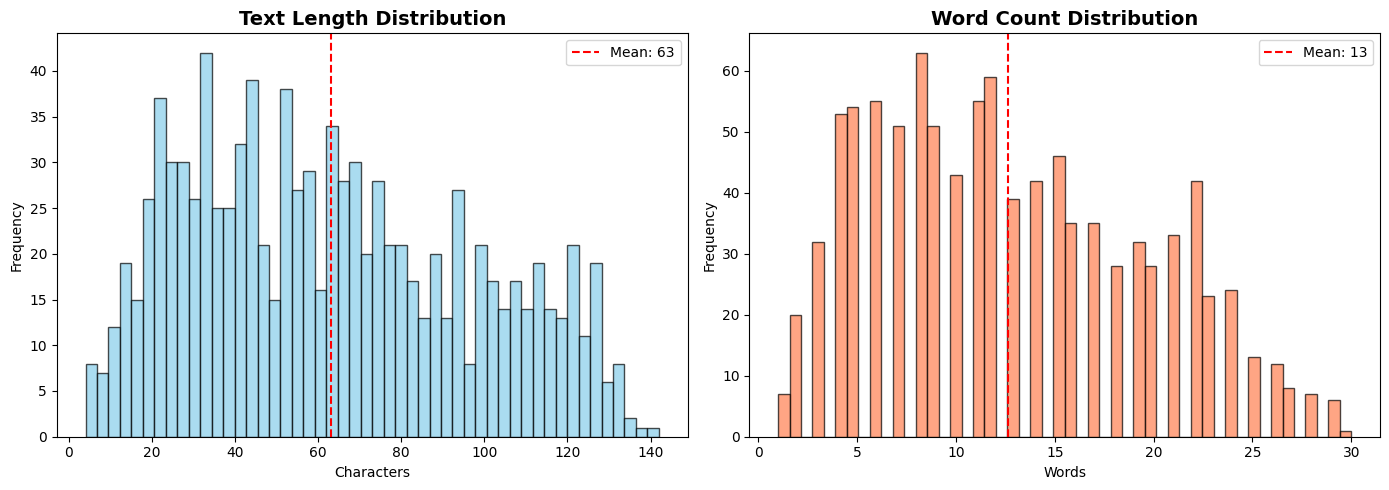


✓ Text statistics visualization saved


In [149]:
# Text statistics
df_clean['text_length'] = df_clean['cleaned_text'].str.len()
df_clean['word_count'] = df_clean['cleaned_text'].str.split().str.len()

print("="*60)
print("TEXT STATISTICS")
print("="*60)

print("\nText length (characters):")
print(df_clean['text_length'].describe())

print("\nWord count:")
print(df_clean['word_count'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Text length distribution
axes[0].hist(df_clean['text_length'], bins=50,
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Characters')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_clean['text_length'].mean(), color='red', linestyle='--',
                label=f"Mean: {df_clean['text_length'].mean():.0f}")
axes[0].legend()

# Word count distribution
axes[1].hist(df_clean['word_count'], bins=50,
             color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df_clean['word_count'].mean(), color='red', linestyle='--',
                label=f"Mean: {df_clean['word_count'].mean():.0f}")
axes[1].legend()

plt.tight_layout()
plt.savefig('sentiment140_text_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Text statistics visualization saved")